In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,GlobalMaxPooling2D, Concatenate
from tensorflow.keras import applications
import numpy as np
from tensorflow import keras

In [2]:
ROWS=224
COLS=224
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               rescale=1/255)
train_gen = train_idg.flow_from_directory(
    '../input/datatask2/task2/train',
    target_size=(ROWS, COLS),
    batch_size = 64,
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_directory(
    '../input/datatask2/task2/val',
    target_size=(ROWS, COLS),
    batch_size = 16
)

Found 14465 images belonging to 3 classes.
Found 1808 images belonging to 3 classes.


In [3]:
train_gen.class_indices

{'humanitarian': 0, 'non_informative': 1, 'structure': 2}

In [4]:
class_weights={0:2.0657,1:0.536,2:1.53448}

In [5]:
savemodel = tf.keras.models.load_model('../input/caits224')

2022-05-29 07:11:34.500185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 07:11:34.629089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 07:11:34.629920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 07:11:34.631092: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
savemodel.summary()

Model: "cai_t"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
projection (Sequential)      (None, 196, 384)          295296    
_________________________________________________________________
projection_dropout (Dropout) multiple                  0         
_________________________________________________________________
sa_ffn_block_0 (Functional)  [(None, None, 384), (None 1775376   
_________________________________________________________________
sa_ffn_block_1 (Functional)  [(None, None, 384), (None 1775376   
_________________________________________________________________
sa_ffn_block_2 (Functional)  [(None, None, 384), (None 1775376   
_________________________________________________________________
sa_ffn_block_3 (Functional)  [(None, None, 384), (None 1775376   
_________________________________________________________________
sa_ffn_block_4 (Functional)  [(None, None, 384), (None 177537

In [7]:
savemodel.trainable=False

In [8]:
image=Input((224,224,3))
out=savemodel(image)
out=Dense(100,activation='relu')(out[0])
out=Dropout(0.3)(out)
o=Dense(3,activation='softmax')(out)
model=Model(inputs=image,outputs=o)

In [9]:
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
cai_t (CaiT)                 ((None, 384), {'sa_ffn_bl 46531200  
_________________________________________________________________
dense (Dense)                (None, 100)               38500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 46,570,003
Trainable params: 38,803
Non-trainable params: 46,531,200
_________________________________________________________________


In [10]:
from tensorflow import keras

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss-cait', monitor='loss', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss-cait', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [es, mc,ms] #early


history = model.fit(train_gen,
                              validation_data=val_gen, 
                              epochs=100, 
                              shuffle=True, 
                              verbose=True,
                                class_weight=class_weights,
                              callbacks=callbacks_list)

2022-05-29 07:12:17.431745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-29 07:12:35.832627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


227/227 [==============================] - 454s 2s/step - loss: 0.7371 - accuracy: 0.6992 - precison: 0.7289 - recall: 0.6557 - val_loss: 0.5406 - val_accuracy: 0.7721 - val_precison: 0.8035 - val_recall: 0.7373


2022-05-29 07:19:57.883043: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
227/227 [==============================] - 360s 2s/step - loss: 0.5996 - accuracy: 0.7512 - precison: 0.7777 - recall: 0.7166 - val_loss: 0.4998 - val_accuracy: 0.7981 - val_precison: 0.8230 - val_recall: 0.7688


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
227/227 [==============================] - 369s 2s/step - loss: 0.5656 - accuracy: 0.7700 - precison: 0.7924 - recall: 0.7372 - val_loss: 0.4819 - val_accuracy: 0.8064 - val_precison: 0.8239 - val_recall: 0.7815


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
227/227 [==============================] - 367s 2s/step - loss: 0.5435 - accuracy: 0.7717 - precison: 0.7970 - recall: 0.7422 - val_loss: 0.4921 - val_accuracy: 0.7954 - val_precison: 0.8165 - val_recall: 0.7754


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
227/227 [==============================] - 364s 2s/step - loss: 0.5300 - accuracy: 0.7773 - precison: 0.8016 - recall: 0.7495 - val_loss: 0.5128 - val_accuracy: 0.7915 - val_precison: 0.8075 - val_recall: 0.7655


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
227/227 [==============================] - 365s 2s/step - loss: 0.5259 - accuracy: 0.7768 - precison: 0.7991 - recall: 0.7488 - val_loss: 0.4776 - val_accuracy: 0.8147 - val_precison: 0.8268 - val_recall: 0.7920


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
227/227 [==============================] - 366s 2s/step - loss: 0.5068 - accuracy: 0.7899 - precison: 0.8097 - recall: 0.7607 - val_loss: 0.4652 - val_accuracy: 0.8136 - val_precison: 0.8273 - val_recall: 0.7948


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
227/227 [==============================] - 358s 2s/step - loss: 0.4952 - accuracy: 0.7929 - precison: 0.8132 - recall: 0.7676 - val_loss: 0.4777 - val_accuracy: 0.8059 - val_precison: 0.8240 - val_recall: 0.7871


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
227/227 [==============================] - 360s 2s/step - loss: 0.4853 - accuracy: 0.7940 - precison: 0.8135 - recall: 0.7730 - val_loss: 0.4652 - val_accuracy: 0.8131 - val_precison: 0.8279 - val_recall: 0.7954


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
227/227 [==============================] - 359s 2s/step - loss: 0.4777 - accuracy: 0.7968 - precison: 0.8176 - recall: 0.7759 - val_loss: 0.4653 - val_accuracy: 0.8025 - val_precison: 0.8207 - val_recall: 0.7821


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
227/227 [==============================] - 360s 2s/step - loss: 0.4696 - accuracy: 0.8018 - precison: 0.8195 - recall: 0.7817 - val_loss: 0.4760 - val_accuracy: 0.8119 - val_precison: 0.8247 - val_recall: 0.7965


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
227/227 [==============================] - 359s 2s/step - loss: 0.4574 - accuracy: 0.8066 - precison: 0.8250 - recall: 0.7870 - val_loss: 0.4808 - val_accuracy: 0.8108 - val_precison: 0.8236 - val_recall: 0.7904


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
227/227 [==============================] - 359s 2s/step - loss: 0.4564 - accuracy: 0.8054 - precison: 0.8225 - recall: 0.7848 - val_loss: 0.4829 - val_accuracy: 0.8025 - val_precison: 0.8164 - val_recall: 0.7893


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/100
227/227 [==============================] - 357s 2s/step - loss: 0.4505 - accuracy: 0.8113 - precison: 0.8285 - recall: 0.7882 - val_loss: 0.4807 - val_accuracy: 0.8048 - val_precison: 0.8170 - val_recall: 0.7954


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/100
227/227 [==============================] - 359s 2s/step - loss: 0.4461 - accuracy: 0.8120 - precison: 0.8310 - recall: 0.7929 - val_loss: 0.4762 - val_accuracy: 0.8114 - val_precison: 0.8198 - val_recall: 0.7954


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 00015: early stopping


In [28]:
savemodel = tf.keras.models.load_model('best_model_alt-valloss-cait')

In [21]:
def norm(img):
    for i in range(len(img)):
        for j in range(len(img[i])):
            for k in range(len(img[i][j])):
                img[i][j][k]/=255
    

In [29]:
import os
predicted=[]
real=[]
i=0
for dir in os.listdir("../input/datatask2/task2/test"):
    if dir=='humanitarian':
        r=0
    elif dir =='non_informative':
        r=1
    else:
        r=2
    for path in os.listdir(f'../input/datatask2/task2/test/{dir}'):
        p=f'../input/datatask2/task2/test/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(224, 224)
)
       
        img_array = tf.keras.utils.img_to_array(img)
        norm(img_array)
        if(i%200==0):
            print(i)
        i+=1
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))

0


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


200
400
600
800
1000
1200
1400
1600
1800


In [30]:
from sklearn import metrics
print(metrics.classification_report(real,predicted))
print(metrics.confusion_matrix(real,predicted))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       284
           1       0.92      0.84      0.88      1131
           2       0.77      0.82      0.80       394

    accuracy                           0.82      1809
   macro avg       0.76      0.81      0.78      1809
weighted avg       0.84      0.82      0.83      1809

[[215  51  18]
 [106 946  79]
 [ 41  28 325]]


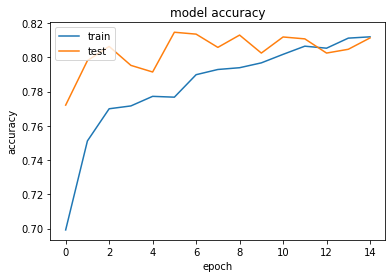

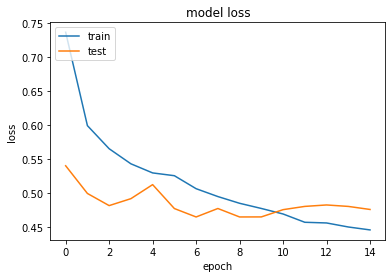

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

In [34]:
import shutil
dir_name='./best_model_alt-valloss-cait'
shutil.make_archive('best-model-valloss-cait', 'zip', dir_name)

'/kaggle/working/best-model-valloss-cait.zip'

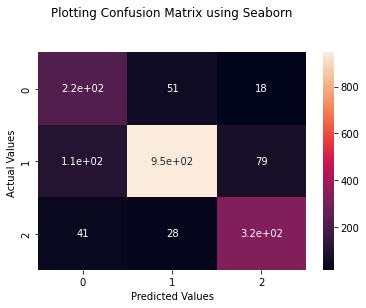

In [33]:
conf_matrix = (confusion_matrix(real, predicted))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True)

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

# labels the boxes
